In [1]:
import random
import numpy as np
import pandas as pd
import manage_data as md
import preprocessing as pp
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import metrics

In [2]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17, fontstyle='oblique')
    plt.colorbar()
    ax = plt.subplot()
    tick_marks = np.arange(2)
    labels = ['Sticking', 'Fine']
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    width, height = cm.shape
    for x in xrange(width):
        xx = np.round(x, 2)
        for y in xrange(height):
            yy = np.round(y, 2)
            valeur = str(int(np.round(100 * cm[x][y],0)))+'%'
            ax.annotate(valeur, xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        size=15)

def concat_df(coil_list):
    big_df = md.importPeak(coil_list[0]).dropna()
    for coil in coil_list[1:]:
        df = md.importPeak(coil).dropna()
        big_df = pd.concat([big_df, df], ignore_index=True)
    return big_df

def create_DB(df):
    feature_col = ['Ximf0', 'Ximf1', 'Ximf2', 'Yimf0', 'Yimf1', 'Yimf2', 'thickness', 'speed']
    X = df[feature_col].values
    Y = df[['sticking']]
    Y = np.array(Y.sticking.values[:], dtype=bool)
    return X, Y

def random_sample(coil_list):
    df = concat_df(coil_list)
    sticking_index = list(df[df.sticking==True].index)
    non_sticking_index = list(df[df.sticking==False].index)
    group_of_items = non_sticking_index               # a sequence or set will work here.
    num_to_select = len(df[df.sticking==True])        # set the number to select here.
    list_of_random_items = random.sample(group_of_items, num_to_select)
    list_of_random_items
    ind = sticking_index+list_of_random_items
    return df.loc[ind]

def random_coils_selection(coil_list, ratio=0.5):
    aux  = list(coil_list)
    random.shuffle(aux)
    n = int(ratio * len(aux))+1
    return aux[:n], aux[n:]

def result_per_coil(coil_list, estimator):
    sum_true = []
    sum_predict = []
    for coil in coil_list:
        df_test = concat_df([coil])
        X_test, Y_true = create_DB(df_test)
        Y_predict = estimator.predict(X_test)
        sum_true.append(sum(Y_true))
        sum_predict.append(sum(Y_predict))
    d = {'truth':sum_true, 'prediction':sum_predict}
    result = pd.DataFrame(d, index=coil_list)
    return result, np.array(sum_true), np.array(sum_predict)

# About DB

In [3]:
all_coils = list( set(range(88)) - set([31]) )

In [4]:
learning_sticking_coil = sorted([7, 28, 49, 50, 78, 79, 81, 82, 62, 74])
big_sticking_error = [13, 38, 40, 65] + [29, 34, 37, 44, 52, 53, 56] + [4, 17, 20]
learning_fine_coils = sorted([10, 24, 25, 30, 33, 42, 46, 47, 48, 85])
big_fine_error = [36, 77]+[1, 5, 11, 15, 45, 57, 75] + [0, 12, 14, 18, 26]
big_fine_error += [35, 39, 41, 51, 54, 59, 63, 68, 69, 70, 73, 76, 84, 87]
learning_coils = learning_sticking_coil + learning_fine_coils
learning_coils += big_fine_error
learning_coils += big_sticking_error
testing_coils = list(set(range(88)) - set(learning_coils) - set({31}))
n = len(learning_coils)+len(testing_coils)
nl = int(np.round(len(learning_coils)*100./n,0))
nt = int(np.round(len(testing_coils)*100./n,0))
print(str(nl)+'% learning coils: '+str(len(learning_coils)))
print(str(nt)+'% testing coils: '+str(len(testing_coils)))

71% learning coils: 62
29% testing coils: 25


In [5]:
learning_coils, testing_coils = random_coils_selection(all_coils)
n = len(learning_coils)+len(testing_coils)
nl = int(np.round(len(learning_coils)*100./n,0))
nt = int(np.round(len(testing_coils)*100./n,0))
print(str(nl)+'% learning coils: '+str(len(learning_coils)))
print(str(nt)+'% testing coils: '+str(len(testing_coils)))

51% learning coils: 44
49% testing coils: 43


In [6]:
graph_title_suffix = '\n 50/50'

In [7]:
df_total = concat_df(all_coils)
df_total_train = concat_df(learning_coils)
df_total_test = concat_df(testing_coils)
df_total_train.head()

,Ximf0,Ximf1,Ximf2,Yimf0,Yimf1,Yimf2,coil,speed,sticking,thickness,time_begin,time_end
0,2.00020,2.80028,2.40024,48.677390,18.278043,10.615784,10,796.450339,False,0.9,64.0,68.0
1,2.80028,1.60016,1.60016,9.983598,8.413813,8.266565,10,891.761242,False,0.9,68.0,72.0
2,3.20032,3.20032,6.00060,20.694303,3.976357,1.940426,10,987.680111,False,0.9,72.0,76.0
3,6.00060,6.80068,6.80068,5.232681,3.821831,3.351059,10,1083.858527,False,0.9,76.0,80.0
4,7.20072,6.40064,6.80068,7.698287,2.496469,1.608068,10,1174.633995,False,0.9,80.0,84.0


# Classifier setting

In [35]:
X_train, Y_train = create_DB(df_total_train)
X_test, Y_true = create_DB(df_total_test)
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, Y_train)

# Result per 4s slice

[[ 14 252]
 [  4 942]]
[[ 0.05263158  0.94736842]
 [ 0.00422833  0.99577167]]


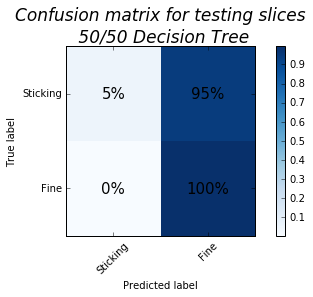

In [36]:
Y_predict = clf.predict(X_test)
cm = metrics.confusion_matrix(Y_true, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing slices'+graph_title_suffix+' Decision Tree'
plot_confusion_matrix(cm_normalized, title=cm_title)
print(cm)
print(cm_normalized)

# Show learning DB

## On coils

[[ 5 14]
 [ 0 25]]
[[ 0.26315789  0.73684211]
 [ 0.          1.        ]]


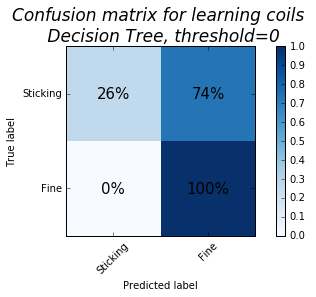

In [37]:
threshold = 0
suffix = 'threshold='+str(threshold)
result_DB, sumtrue, sumpredict = result_per_coil(learning_coils, clf)
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(
                    cm_normalized, 
                    'Confusion matrix for learning coils \n Decision Tree, '+suffix)
print(cm)
print(cm_normalized)

## On 4s slices

[[ 27 252]
 [  0 951]]
[[ 0.09677419  0.90322581]
 [ 0.          1.        ]]


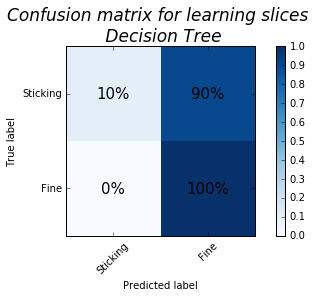

In [38]:
Y_predict = clf.predict(X_train)
cm = metrics.confusion_matrix(Y_train, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'Confusion matrix for learning slices \n Decision Tree')
print(cm)
print(cm_normalized)

# Result per coil

In [39]:
result, sumtrue, sumpredict = result_per_coil(testing_coils, clf)

[[ 2 18]
 [ 0 23]]
[[ 0.1  0.9]
 [ 0.   1. ]]


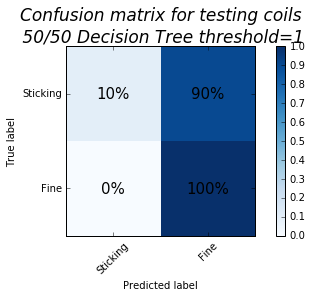

In [40]:
threshold = 1
suffix = ' Decision Tree threshold='+str(threshold)
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing coils'+graph_title_suffix+suffix
plot_confusion_matrix(cm_normalized, title=cm_title)
print(cm)
print(cm_normalized)

## Sticking detection failure

### False negative

In [41]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
l = sorted(list(selection.index))
print(selection)
print(l)
print(len(l))
print(selection.prediction.mean())
print(selection.truth.mean())

    prediction  truth
74           0     12
6            0     10
44           0      2
66           0     10
56           0      6
32           0     12
81           0     29
49           0     29
53           0      8
38           0     15
8            0      7
17           0      2
78           0     29
37           0      5
62           0     11
4            0      5
82           0     28
13           0     16
[4, 6, 8, 13, 17, 32, 37, 38, 44, 49, 53, 56, 62, 66, 74, 78, 81, 82]
18
0.0
13.1111111111


### False positive

In [42]:
selection = result[(result.truth==0) & (result.prediction>threshold)]
l2 = sorted(list(selection.index))
print(selection)
print(l2)
print(len(l2))
print(selection.prediction.mean())
np.abs(sumtrue-sumpredict).mean()

Empty DataFrame
Columns: [prediction, truth]
Index: []
[]
0
nan


5.9069767441860463

## Data representation

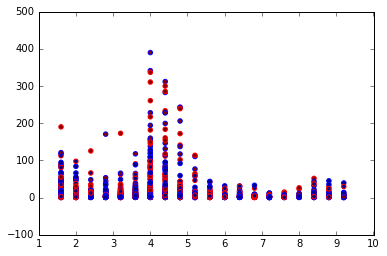

In [43]:
# this formatter will label the colorbar with the correct target names
#formatter = plt.FuncFormatter(lambda i, *args: iris.target_names[int(i)])
plt.scatter(df_total.Ximf2, df_total.Yimf2, c=df_total.sticking, color=["b", "r"])
#plt.colorbar(ticks=[0, 1, 2], format=formatter)
#plt.xlabel(iris.feature_names[x_index])
#plt.ylabel(iris.feature_names[y_index])

# Old code results

[[ 9  3]
 [17 15]]
[[ 0.75     0.25   ]
 [ 0.53125  0.46875]]


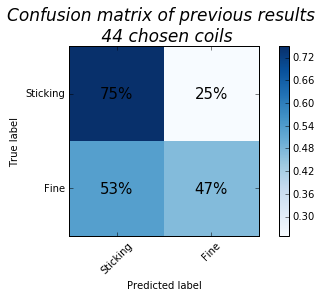

In [44]:
ytrue_old = np.ones(44).astype(bool)
ytrue_old[12:] = False
ytest_old = np.ones(44).astype(bool)
ytest_old[12:] = False
ytest_old[:3] = False
ytest_old[-17:] = True
sum(ytrue_old)
sum(ytest_old)
cm = metrics.confusion_matrix(ytrue_old, ytest_old, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, 'Confusion matrix of previous results \n 44 chosen coils')
print(cm)
print(cm_normalized)

# Plot sticking and prediction per coil

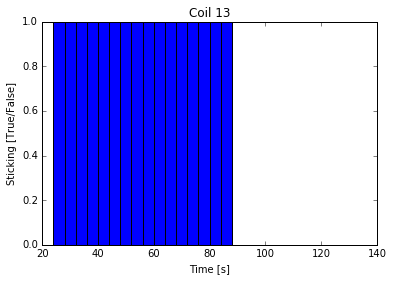

In [45]:
coil = l[3] #testing_coils[13]
df_raw = md.import_data(coil)
df_peak = md.importPeak(coil)
df_one_coil = concat_df([coil])
X_coil, Y_coil = create_DB(df_one_coil)
Y_pred_coil = clf.predict(X_coil)
df_one_coil['prediction'] = Y_pred_coil
x = (df_one_coil.time_begin.values + df_one_coil.time_end.values)/2.
plt.title('Coil '+str(coil))
plt.bar(x, df_one_coil.sticking.values,4)
plt.bar(x, 1./2*df_one_coil.prediction.values,4,color='g')
plt.xlabel('Time [s]')
plt.ylabel('Sticking [True/False]')

In [46]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
l = sorted(list(selection.index))
print(selection)
print(l)
print(len(l))
print(selection.prediction.mean())
print(selection.truth.mean())

    prediction  truth
74           0     12
6            0     10
44           0      2
66           0     10
56           0      6
32           0     12
81           0     29
49           0     29
53           0      8
38           0     15
8            0      7
17           0      2
78           0     29
37           0      5
62           0     11
4            0      5
82           0     28
13           0     16
[4, 6, 8, 13, 17, 32, 37, 38, 44, 49, 53, 56, 62, 66, 74, 78, 81, 82]
18
0.0
13.1111111111


# K-Means

In [47]:
from sklearn import cluster
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(X_train)
k_means = cluster.KMeans(n_clusters=2)
k_means.fit(X_train)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

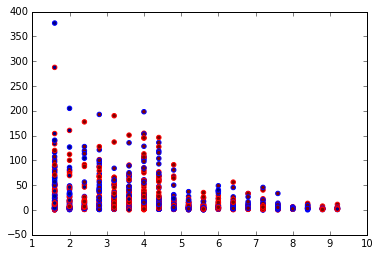

In [48]:
axeX = 0
axeY = axeX + 3
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.scatter(X_train[:, axeX], X_train[:, axeY], c=k_means.labels_, color=['b', 'r'])

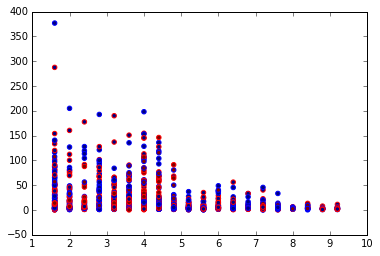

In [49]:
fig = plt.figure(2)
ax = fig.add_subplot(111)
ax.scatter(X_train[:, axeX], X_train[:, axeY], c=Y_train.astype(int), color=['b', 'r'])

# K-means result per 4s slices

[[175  91]
 [697 249]]
[[ 0.65789474  0.34210526]
 [ 0.73678647  0.26321353]]


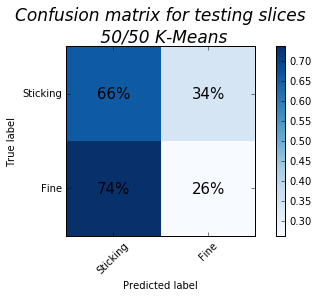

In [64]:
Y_predict = k_means.predict(X_test)
cm = metrics.confusion_matrix(Y_true, Y_predict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing slices'+graph_title_suffix+' K-Means'
plot_confusion_matrix(cm_normalized, title=cm_title)
print(cm)
print(cm_normalized)

In [65]:
result, sumtrue, sumpredict = result_per_coil(testing_coils, estimator=k_means)

[[19  1]
 [21  2]]
[[ 0.95        0.05      ]
 [ 0.91304348  0.08695652]]


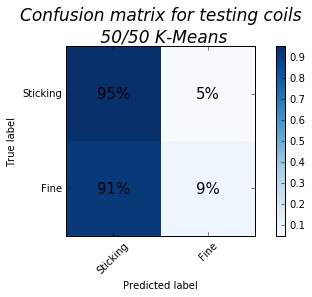

In [66]:
threshold = 0
ytrue = np.greater(sumtrue, 0)
ypredict = np.greater(sumpredict, threshold)
cm = metrics.confusion_matrix(ytrue, ypredict, labels=[True, False])
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_title = 'Confusion matrix for testing coils'+graph_title_suffix+' K-Means'
plot_confusion_matrix(cm_normalized, title=cm_title)
print(cm)
print(cm_normalized)

# K-means sticking detection failure

## False negative

In [67]:
selection = result[(result.truth>0) & (result.prediction<threshold+1)]
lkmeans = sorted(list(selection.index))
print(selection)
print(lkmeans)
print(len(lkmeans))
print(selection.prediction.mean())
print(selection.truth.mean())

    prediction  truth
13           0     16
[13]
1
0.0
16.0


## False positive

In [68]:
selection = result[(result.truth==0) & (result.prediction>threshold)]
lkmeans2 = sorted(list(selection.index))
print(selection)
print(lkmeans2)
print(len(lkmeans2))
print(selection.prediction.mean())

    prediction  truth
42          28      0
63          14      0
59          29      0
47          29      0
87          29      0
67          25      0
48          29      0
36          26      0
14          18      0
70          23      0
76           9      0
33          22      0
23          28      0
84          22      0
86          15      0
73          10      0
54          22      0
26          27      0
1           27      0
22          28      0
35          26      0
[1, 14, 22, 23, 26, 33, 35, 36, 42, 47, 48, 54, 59, 63, 67, 70, 73, 76, 84, 86, 87]
21
23.1428571429


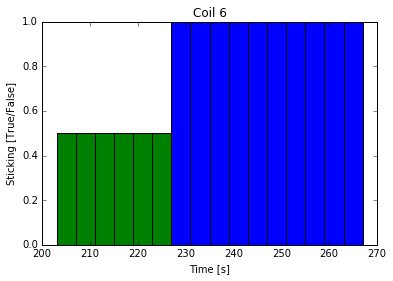

In [69]:
coil = 6 #testing_coils[13]
df_raw = md.import_data(coil)
df_peak = md.importPeak(coil)
df_one_coil = concat_df([coil])
X_coil, Y_coil = create_DB(df_one_coil)
Y_pred_coil = k_means.predict(X_coil)
df_one_coil['prediction'] = Y_pred_coil
x = (df_one_coil.time_begin.values + df_one_coil.time_end.values)/2.
plt.title('Coil '+str(coil))
plt.bar(x, df_one_coil.sticking.values,4)
plt.bar(x, 1./2*df_one_coil.prediction.values,4,color='g')
plt.xlabel('Time [s]')
plt.ylabel('Sticking [True/False]')